In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # ignore warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None) # display all columns for the dataframes

In [49]:
df = pd.read_csv('data/train.csv')
print(df.shape)
df.head()

(106, 14)


,Target,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,2,12.00,1.51,2.42,22.0,86,1.45,1.25,0.50,1.63,3.60,1.05,2.65,450
1,1,13.68,1.83,2.36,17.2,104,2.42,2.69,0.42,1.97,3.84,1.23,2.87,990
2,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045
3,3,12.81,2.31,2.40,24.0,98,1.15,1.09,0.27,0.83,5.70,0.66,1.36,560
4,1,13.30,1.72,2.14,17.0,94,2.40,2.19,0.27,1.35,3.95,1.02,2.77,1285


# Data preprocessing

In [50]:
df.isnull().sum() # No missing values

Target                          0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

In [51]:
df.corrwith(df["Target"]) # All columns are quite correlated to the target column

Target                          1.000000
Alcohol                        -0.376731
Malic acid                      0.490469
Ash                            -0.118090
Alcalinity of ash               0.506086
Magnesium                      -0.300758
Total phenols                  -0.724383
Flavanoids                     -0.829121
Nonflavanoid phenols            0.481201
Proanthocyanins                -0.538216
Color intensity                 0.228815
Hue                            -0.680115
OD280/OD315 of diluted wines   -0.776758
Proline                        -0.649673
dtype: float64

# Splitting and Scaling data

In [52]:
# Split data
X = df.iloc[:, 1:].to_numpy()
y = df.iloc[:, 0].to_numpy()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data

In [53]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Model Selection

In [54]:
from sklearn.model_selection import (cross_val_score, GridSearchCV)
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [55]:
tuned_parameters_GaussianNB = {'var_smoothing': np.logspace(0,-9, num=100)}
tuned_parameters_KNN = [{"n_neighbors": [2, 4, 6, 10, 14]}]
tuned_parameters_SVC = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]
tuned_parameter_DT = [{
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
}]
tuned_parameter_RF = [{
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}]

In [56]:
models_data=[
    ("Gauss Naive Baise", GaussianNB(), tuned_parameters_GaussianNB),
    ("K Nearest Neihbours", KNeighborsClassifier(), tuned_parameters_KNN),
    ("Support Vector Machine", SVC(), tuned_parameters_SVC),
    ("Decision Tree", DecisionTreeClassifier(), tuned_parameter_DT),
    ("Random Forest", RandomForestClassifier(), tuned_parameter_RF)
]

In [57]:
scores = ["precision", "recall"]
model_results = {}

for score in scores:
    model_results[score] = {}
    print("# Tuning hyper-parameters for %s" % score)
    print()
    for name, model, tuned_parameters in models_data:
        print("-------------------------------")
        print(name)
        print("-------------------------------")
        model = GridSearchCV(model, tuned_parameters, scoring="%s_macro" % score)
        model.fit(X_train, y_train)
        model_results[score][name] = model # save best models
        
        print("Best parameters set found on development set:")
        print()
        print(model.best_params_, model.best_score_)
        print()
        print("Grid scores on development set:")
        print()
        means = model.cv_results_["mean_test_score"]
        stds = model.cv_results_["std_test_score"]
        for mean, std, params in zip(means, stds, model.cv_results_["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, model.predict(X_test)
        print(classification_report(y_true, y_pred))
        print("-------------------------------")
        print()

# Tuning hyper-parameters for precision

-------------------------------
Gauss Naive Baise
-------------------------------
Best parameters set found on development set:

{'var_smoothing': 0.12328467394420659} 0.9916666666666668

Grid scores on development set:

0.968 (+/-0.055) for {'var_smoothing': 1.0}
0.968 (+/-0.055) for {'var_smoothing': 0.8111308307896871}
0.968 (+/-0.055) for {'var_smoothing': 0.657933224657568}
0.968 (+/-0.055) for {'var_smoothing': 0.533669923120631}
0.977 (+/-0.057) for {'var_smoothing': 0.43287612810830584}
0.977 (+/-0.057) for {'var_smoothing': 0.3511191734215131}
0.990 (+/-0.038) for {'var_smoothing': 0.2848035868435802}
0.990 (+/-0.038) for {'var_smoothing': 0.23101297000831597}
0.990 (+/-0.038) for {'var_smoothing': 0.1873817422860384}
0.982 (+/-0.044) for {'var_smoothing': 0.15199110829529336}
0.992 (+/-0.033) for {'var_smoothing': 0.12328467394420659}
0.992 (+/-0.033) for {'var_smoothing': 0.1}
0.992 (+/-0.033) for {'var_smoothing': 0.08111308307896872

In [58]:
for score in model_results:
    print("# Best models for %s" % score)
    model_result = model_results[score]
    for key in model_result:
        model = model_result[key]
        print(key, model.best_params_, model.best_score_)

# Best models for precision
Gauss Naive Baise {'var_smoothing': 0.12328467394420659} 0.9916666666666668
K Nearest Neihbours {'n_neighbors': 14} 0.9821428571428573
Support Vector Machine {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'} 0.9916666666666668
Decision Tree {'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 8} 0.936904761904762
Random Forest {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200} 1.0
# Best models for recall
Gauss Naive Baise {'var_smoothing': 0.2848035868435802} 0.9904761904761905
K Nearest Neihbours {'n_neighbors': 14} 0.9738095238095237
Support Vector Machine {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'} 0.9833333333333332
Decision Tree {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 12} 0.9192063492063494
Random Forest {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200} 1.0


# Cross validation

We have limited data, so let's cross validate some of the best models

In [59]:
models_data=[
    ("Gauss Naive Baise", GaussianNB(var_smoothing=0.12328467394420659)),
    ("K Nearest Neihbours", KNeighborsClassifier(n_neighbors=14)),
    ("Support Vector Machine", SVC(C=1000, gamma=0.001, kernel='rbf')),
    ("Decision Tree", DecisionTreeClassifier(max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=8)),
    ("Random Forest", RandomForestClassifier(criterion='gini', max_depth=4, n_estimators=200))
]

In [61]:
X = scaler.transform(X)

In [62]:
from sklearn.model_selection import cross_val_score
for name, model in models_data:
    scores = cross_val_score(model, X, y, cv=5)
    print(name, scores.mean())

Gauss Naive Baise 0.9813852813852814
K Nearest Neihbours 0.9722943722943722
Support Vector Machine 0.9623376623376624
Decision Tree 0.8588744588744589
Random Forest 0.9813852813852814


In [63]:
# Функція для виведення точності моделі
def estimate(model, y_pred, y_test):
    #y_pred = model.predict(X_test)
    mislabeled_num = (y_test != y_pred).sum()
    precision = 1.0 - (mislabeled_num/X_test.shape[0])
    error = np.mean(y_pred != y_test)
    print("Number of mislabeled points out of a total %d points: %d with precision: %f" % 
          (X_test.shape[0], mislabeled_num, precision))
    return precision, error
from sklearn.metrics import confusion_matrix
import seaborn as sns
def confusion(y_pred, y_true, ax):
    cm = confusion_matrix(y_true, y_pred)
    ax.set_xticks(())
    ax.set_yticks(())
    sns.heatmap(cm, annot=True, cbar=False, fmt='g', ax = ax); #annot=True to annotate cells

# Build and save models

In [67]:
import pickle
X_test = scaler.transform(X_test)

In [68]:
def model_analysis(model, X_train, y_train, X_test, y_test, name):
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, error = estimate(model, y_pred, y_test)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    confusion(y_pred, y_test, axs)
    with open('models/' + name + '.pickle', 'wb')as f:
        pickle.dump(model, f)

Number of mislabeled points out of a total 22 points: 1 with precision: 0.954545


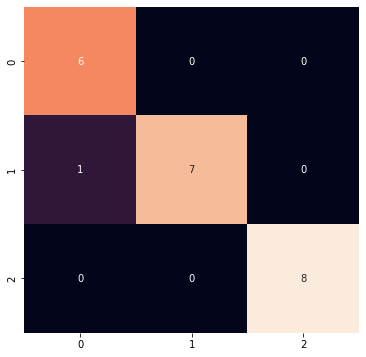

In [69]:
model = GaussianNB(var_smoothing=0.12328467394420659)
model_analysis(model, X_train, y_train, X_test, y_test, "GNB")

Number of mislabeled points out of a total 22 points: 1 with precision: 0.954545


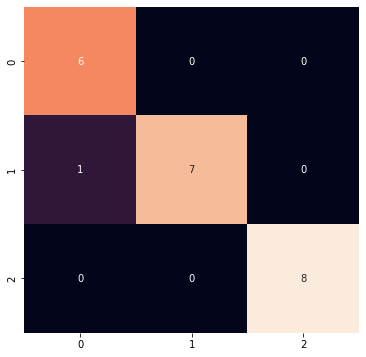

In [70]:
model = RandomForestClassifier(criterion='gini', max_depth=4, n_estimators=200)
model_analysis(model, X_train, y_train, X_test, y_test, "RF")

# Predictions

In [72]:
model = pickle.load(open('models/RF.pickle', 'rb'))

In [73]:
df = pd.read_csv('data/test.csv')
print(df.shape)
df.head()

(72, 14)


,index,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,12.93,2.81,2.70,21.0,96,1.54,0.50,0.53,0.75,4.60,0.77,2.31,600
1,2,13.17,5.19,2.32,22.0,93,1.74,0.63,0.61,1.55,7.90,0.60,1.48,725
2,3,12.08,1.33,2.30,23.6,70,2.20,1.59,0.42,1.38,1.74,1.07,3.21,625
3,4,12.85,1.60,2.52,17.8,95,2.48,2.37,0.26,1.46,3.93,1.09,3.63,1015
4,5,12.72,1.81,2.20,18.8,86,2.20,2.53,0.26,1.77,3.90,1.16,3.14,714


In [74]:
X_res = df.iloc[:, 1:].to_numpy()

In [75]:
X_res = scaler.transform(X_res)

In [76]:
y_res = model.predict(X_res)

In [77]:
np.savetxt("data/submission.csv", np.dstack((np.arange(1, y_res.size+1),y_res))[0],"%d,%d",header="ImageId,Label")